# Strategy

- Preprocessing
    - Remove ctrl_vehicle
    - RankGauss
    - PCA + Existing Features
    - KMeans
    - Basic stats
- Model
    - Multi head ResNet (tensorflow)
    - TabNet (pytorch)
- Training
    - Pre-train with non-scored target.
    - Train with public test pseudo label
    - Optimizer: Adam/AdamW with weight_decay
    - Loss: BCE with Label smoothing + Logits
- Prediction
    - Ensemble above.

# Score

| Version | LB         | CV                      | AUC                   | CV Strategy | Fold | Seed | Execution Time | Comment |
| ---     | ---        | ---                     | ---                   | ---         | ---  | ---  | ---            | ---     |
| v65     | 0.01823    | 0.01617542475216824     | -                     | old         | 5    | 3    | 4697s          | -       |
| v80     | 0.01837    | 0.01667020593849        | 0.6648896787429924    | new         | 5    | 3    | 4421s          | (a)     |
| v82     | 0.01831    | 0.015602756672807215    | 0.8186556909524331    | old         | 5    | 3    | 4997s          | (a)     |
| v84     | 0.01835    | 0.016074252564811344    | 0.7612621209944287    | ensemble    | 5    | 2    | 6314s          | (a)     |
| v85     | 0.01828    | 0.015434994072972176    | 0.8286985624571163    | old         | 5    | 3    | 5117s          | -       |
| v86     | 0.01830    | 0.015259595245052899    | 0.8452802832071501    | old         | 5    | 3    | 5009s          | -       |
| v87     | 0.01828    | 0.015175610900380308    | 0.8423746866733632    | old         | 5    | 3    | 5431s          | -       |
| v88     | 0.01833    | 0.016577553117110334    | 0.6818396112329141    | new         | 5    | 3    | 4514s          | -       |
| v89     | 0.01829    | 0.015641367689461786    | 0.8047873468589011    | ensemble    | 5    | 2    | 6780s          | -       |
| v91     |            |                         |                       | new         | 5    | 3    |                | -       |

(a): Same model.

# Change Log

- v65
    - Remove clipping.
    - Disable Variance Encoding.
- v66
    - Add AUC.
    - CV only with original training data.
- v67
    - Add `train_drug.csv` .
    - Add Drug and MultiLabel Stratification.
- v68
    - Remove public test pseudo label.
    - Enable pseudo labeling.
    - Disable pre-training with non-scored target.
- V69
    - Disable pseudo labeling.
    - Re-enable pre-training with non-scored target.
    - Re-add public test pseudo label.
    - Add correlation.
    - Update label smoothing parameter.
- v70
    - Amend num of seed.
- v71
    - Update model parameters.
        - ResNet network
        - TabNet dimension
- v72
    - Add KMeans and basic stats.
    - Add NODE model.
- v73
    - Update split condition of group multilabel stratified kfold.
    - Update NODE parameters.
- v74
    - Disable pre-train with non-scored target due to execution time reduction.
- v75
    - Fold 5 to 7.
- v76
    - Remove ResNet for execution time reduction.
- v77
    - Use 3 models. ["ResNet", "TabNet", "NODE"]
    - Enable pre-train for ResNet.
- v78
    - Reset fold eash seeds.
- v79
    - Add simple NN model again.
    - Fold 7 to 5.
- v80
    - Remove simple NN and NODE model.
    - Increase num of seed x2 to x3.
- v81
    - Use ctrl_vehicle.
- v82
    - Remove ctrl_vehicle.
    - Add flag to disable cv_with_drug_id. Disable for now.
        - It may be good options that
            - is enabled for parameter tuning.
            - is disabled for training.
- v83
    - Change input of ResNet network.
- v84
    - Revert v83.
    - Ensemble old and new cv predictions.
- v85
    - Separate model by CV.
    - Use old cv oriented model.
- v86
    - Update public test label to v65.
- v87
    - Remove unused code.
        - Model(SimpleNN, NODE)
        - Pseudo labeling
        - Variable(CV_WITH_DRUG_ID)
        - AdaBelief
        - Weighted ensemble
        - Clipping
    - Hyper parameter tuning for ResNet to use 5 layers.
- v90
    - Hyper parameter tuning for New CV on ResNet.
    - Blend weight optimization.

# Setup

## Variables

In [ ]:
import sys

IN_COLAB = "google.colab" in sys.modules

In [ ]:
USE_PUBLIC_TEST_PSEUDO_LABEL = True

In [ ]:
PRE_TRAIN_NON_SCORED_TARGET = True

In [ ]:
HYPER_PARAMETER_TUNING = False

if HYPER_PARAMETER_TUNING:
    TUNING_RESNET = True
    TUNING_TABNET = False

    USE_PUBLIC_TEST_PSEUDO_LABEL = False
    PRE_TRAIN_NON_SCORED_TARGET = True

## for Google Colab

In [ ]:
COMPETE = "lish-moa"
DATASETS = [
    "imokuri/pytorchtabnet",
    "imokuri/moapublictestpredictions",
    "tolgadincer/autograd",
    "yasufuminakama/iterative-stratification",
    "rahulsd91/moapublictest",
]
PACKAGES = ["optuna"]

In [ ]:
if IN_COLAB:
    !pip install -q -U git+https://github.com/IMOKURI/kaggle_on_google_colab.git

    from kaggle_on_google_colab import setup
    kaggle = setup.Setup()
    kaggle.dirs(COMPETE)

    !kaggle competitions download -p /content/zip {COMPETE}
    for line in setup.exec_get_lines(cmd=f"kaggle competitions files --csv {COMPETE} | egrep -v \"Warning: Looks like you're using an outdated API Version|name,size,creationDate\" | cut -d , -f 1"):
        !unzip -q -n /content/zip/{line.decode().strip()}.zip -d /content/{COMPETE}/input/{COMPETE}

    for dataset in DATASETS:
        dataset_name = dataset.split("/")[-1]

        !kaggle datasets download -p /content/zip {dataset}
        !unzip -q -n /content/zip/{dataset_name}.zip -d /content/{COMPETE}/input/{dataset_name}

    for package_ in PACKAGES:
        !pip install -q {package_}

    !pip install -q -U tensorflow-addons
    !mv /content/zip/train_drug.csv /content/{COMPETE}/input/{COMPETE}/

    %cd /content/{COMPETE}/output


Download 100%.
 95% 52.0M/54.8M [00:02<00:00, 6.68MB/s]
100% 54.8M/54.8M [00:02<00:00, 19.7MB/s]
  0% 0.00/535k [00:00<?, ?B/s]
100% 535k/535k [00:00<00:00, 76.3MB/s]
  0% 0.00/233k [00:00<?, ?B/s]
100% 233k/233k [00:00<00:00, 73.7MB/s]
 55% 5.00M/9.16M [00:01<00:01, 3.30MB/s]
100% 9.16M/9.16M [00:01<00:00, 5.93MB/s]
  0% 0.00/257k [00:00<?, ?B/s]
100% 257k/257k [00:00<00:00, 85.1MB/s]
  0% 0.00/38.9k [00:00<?, ?B/s]
100% 38.9k/38.9k [00:00<00:00, 33.1MB/s]
unzip:  cannot find or open /content/zip/train_drug.csv.zip, /content/zip/train_drug.csv.zip.zip or /content/zip/train_drug.csv.zip.ZIP.
  0% 0.00/84.6k [00:00<?, ?B/s]
100% 84.6k/84.6k [00:00<00:00, 76.8MB/s]
 65% 17.0M/26.3M [00:01<00:01, 5.24MB/s]
100% 26.3M/26.3M [00:01<00:00, 16.0MB/s]
  0% 0.00/2.47M [00:00<?, ?B/s]
100% 2.47M/2.47M [00:00<00:00, 82.0MB/s]
  0% 0.00/10.8k [00:00<?, ?B/s]
100% 10.8k/10.8k [00:00<00:00, 13.8MB/s]
 55% 5.00M/9.16M [00:00<00:00, 13.4MB/s]
100% 9.16M/9.16M [00:00<00:00, 20.7MB/s]
     |████████████

## Library

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import sys

sys.path.append("../input/iterative-stratification/iterative-stratification-master")
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

sys.path.append("../input/autograd")
import autograd.numpy as np
from autograd import grad

sys.path.append("../input/pytorchtabnet")
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
import datetime
import gc
import itertools
import os
import random
from time import time

# import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.regularizers as R
import tensorflow_addons as tfa
import torch
import torch.nn.functional as F
import torch.optim as optim
from scipy.optimize import fsolve, minimize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import QuantileTransformer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from torch import nn
from torch.nn.modules.loss import _WeightedLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau as torch_ReduceLROnPlateau

In [ ]:
if HYPER_PARAMETER_TUNING:
    import optuna

In [ ]:
if IN_COLAB:
    from IPython.display import SVG, display_svg
    from tensorflow.keras.utils import model_to_dot

In [ ]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision

    if tpu:
        policy = tf.keras.mixed_precision.experimental.Policy("mixed_bfloat16")
    else:
        policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
    mixed_precision.set_policy(policy)
    print("Mixed precision enabled")

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print("Accelerated Linear Algebra enabled")

Accelerated Linear Algebra enabled


In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Functions

In [ ]:
def fix_seed(seed=2020):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


random_seed = 22
fix_seed(random_seed)

In [ ]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

## Metrics

In [ ]:
# Evaluation Metric with sigmoid applied and clipping

## for tensorflow
def logloss(y_true, y_pred):
    logits = 1 / (1 + K.exp(-y_pred))
    aux = (1 - y_true) * K.log(1 - logits + 1e-15) + y_true * K.log(logits + 1e-15)
    return K.mean(-aux)


## for pytorch
class LogitsLogLoss(Metric):
    def __init__(self):
        self._name = "logits_ll"
        self._maximize = False

    def __call__(self, y_true, y_pred):
        logits = 1 / (1 + np.exp(-y_pred))
        aux = (1 - y_true) * np.log(1 - logits + 1e-15) + y_true * np.log(logits + 1e-15)
        return np.mean(-aux)


## for overall
## [Fast Numpy Log Loss] https://www.kaggle.com/gogo827jz/optimise-blending-weights-4-5x-faster-log-loss
def metric(y_true, y_pred):
    loss = 0
    for i in range(y_pred.shape[1]):
        loss += -np.mean(
            y_true[:, i] * np.log(y_pred[:, i] + 1e-15) + (1 - y_true[:, i]) * np.log(1 - y_pred[:, i] + 1e-15)
        )
    return loss / y_pred.shape[1]

## Loss functions

In [ ]:
# https://www.kaggle.com/felipebihaiek/torch-continued-from-auxiliary-targets-smoothing
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction="mean", smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets: torch.Tensor, n_labels: int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1), self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets, self.weight)

        if self.reduction == "sum":
            loss = loss.sum()
        elif self.reduction == "mean":
            loss = loss.mean()

        return loss

## Cross Validation

In [ ]:
# Blend oof predictions
def blend(size, weights, oof):
    blend_ = np.zeros(size)
    for i, key in enumerate(oof.keys()):
        blend_ += weights[i] * oof[key].values[: blend_.shape[0], : blend_.shape[1]]
    return blend_

In [ ]:
def cross_validation(size, weight, y_true, oof):
    x = size[0]
    blend_ = blend(y_true[:x].shape, weight, oof)

    aucs = []
    for task_id in range(blend_.shape[1]):
        aucs.append(roc_auc_score(y_true=y_true[:x, task_id], y_score=blend_[:, task_id]))

    CV = metric(y_true[:x], blend_)
    AUC = np.mean(aucs)
    print(f"Blended CV: {CV}, AUC : {AUC}")

    return CV, AUC, pd.DataFrame(blend_)

# Load Data

In [ ]:
train_df = pd.read_csv("../input/lish-moa/train_features.csv")
test_df = pd.read_csv("../input/lish-moa/test_features.csv")
target_df = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
non_target_df = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
submit_df = pd.read_csv("../input/lish-moa/sample_submission.csv")
drug_df = pd.read_csv("../input/lish-moa/train_drug.csv")

pub_test_df = pd.read_csv("../input/moapublictest/test_features.csv")
# pub_submit_df = pd.read_csv("../input/moapublictestpredictions/submission-blendblendblend.csv")
pub_submit_df = pd.read_csv("../input/moapublictestpredictions/submission-v65-old_best_lb.csv")

In [ ]:
train = train_df.copy()
test = test_df.copy()
target = target_df.copy()
non_target = non_target_df.copy()
ss = submit_df.copy()
drug = drug_df.copy()

pub_test = pub_test_df.copy()
pub_ss = pub_submit_df.copy()

## Use public test data for training

In [ ]:
# Merge public test data (and pseudo label) into train data
if USE_PUBLIC_TEST_PSEUDO_LABEL:
    train = pd.concat([train, pub_test]).reset_index(drop=True)
    target = pd.concat([target, pub_ss]).reset_index(drop=True)

In [ ]:
target

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,id_000779bfc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,id_000a6266a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_0015

# Preprocessing

In [ ]:
train.loc[:, "cp_dose"] = train.loc[:, "cp_dose"].map({"D1": 0, "D2": 1})
test.loc[:, "cp_dose"] = test.loc[:, "cp_dose"].map({"D1": 0, "D2": 1})

In [ ]:
train.loc[:, "cp_time"] = train.loc[:, "cp_time"].map({24: 0, 48: 1, 72: 2})
test.loc[:, "cp_time"] = test.loc[:, "cp_time"].map({24: 0, 48: 1, 72: 2})

## Remove ctrl_vehicle



In [ ]:
USE_CTRL_VEHICLE = False

if USE_CTRL_VEHICLE:
    train.loc[:, "cp_type"] = train.loc[:, "cp_type"].map({"ctl_vehicle": 0, "trt_cp": 1})
    test.loc[:, "cp_type"] = test.loc[:, "cp_type"].map({"ctl_vehicle": 0, "trt_cp": 1})

else:
    target = target.loc[train["cp_type"] != "ctl_vehicle"].reset_index(drop=True)
    non_target = non_target.loc[train[: train_df.shape[0]]["cp_type"] != "ctl_vehicle"].reset_index(drop=True)

    train = train.loc[train["cp_type"] != "ctl_vehicle"].reset_index(drop=True)

    train = train.drop("cp_type", axis=1)
    test = test.drop("cp_type", axis=1)

## Merge drug_id into training data

https://www.kaggle.com/c/lish-moa/discussion/195195

In [ ]:
target_drug = pd.DataFrame(target.loc[:, "sig_id"]).merge(drug, on="sig_id", how="left")
non_target_drug = pd.DataFrame(non_target.loc[:, "sig_id"]).merge(drug, on="sig_id", how="left")

In [ ]:
target_drug = target_drug.fillna("xxxxxxxxx")
non_target_drug = non_target_drug.fillna("xxxxxxxxx")

In [ ]:
target_drug

,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c
3,id_0015fd391,8c7f86626
4,id_001626bd3,7cbed3131
...,...,...
25567,id_ff7004b87,xxxxxxxxx
25568,id_ff925dd0d,xxxxxxxxx
25569,id_ffb710450,xxxxxxxxx
25570,id_ffbb869f2,xxxxxxxxx


## Remove sig_id

In [ ]:
del train["sig_id"]
del target["sig_id"]
del non_target["sig_id"]
del test["sig_id"]
del ss["sig_id"]

In [ ]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,0.1656,0.5300,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,0.1256,-0.1219,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,-1.6720,-1.2690,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,1.0620,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25567,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,0.0640,-0.6316,-1.1990,0.7312,0.2752,0.8771,0.7721,-0.6836,-0.7374,-1.1620,0.1262,0.2718,0.3968,-1.1580,0.9891,-0.7642,0.6810,0.8971,0.1092,0.6508,-0.9330,0.1292,-0.5895,0.4987,-0.1180,0.3460,0.6819,-0.9072,1.3150,-0.2573,0.8935,0.7214,...,-0.799

In [ ]:
print(train.shape)
print(target.shape)
print(non_target.shape)

print(test.shape)
print(ss.shape)

(25572, 874)
(25572, 206)
(21948, 402)
(3982, 874)
(3982, 206)


## Rank Gauss

https://www.kaggle.com/nayuts/moa-pytorch-nn-pca-rankgauss



In [ ]:
g_cols = [col for col in train_df.columns if col.startswith("g-")]
c_cols = [col for col in train_df.columns if col.startswith("c-")]

for col in g_cols + c_cols:
    transformer = QuantileTransformer(n_quantiles=100, random_state=random_seed, output_distribution="normal")

    vec_len = len(train[col].values)
    vec_len_test = len(test[col].values)

    raw_vec = train[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test[col] = transformer.transform(test[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

In [ ]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,0,0,1.124260,0.896698,-0.436214,-0.965311,-0.287443,-1.016437,-1.360774,-0.045876,0.724289,-0.306480,1.548505,0.164968,0.662494,-0.546159,0.298915,-1.074307,-1.121108,0.911363,0.371674,-0.522346,-0.697832,-1.373744,-1.688513,1.251776,0.571647,0.442209,0.289814,0.124411,-0.483898,0.763732,0.424105,-1.104934,-0.059676,-0.410229,-0.238182,0.293279,0.385467,-0.575945,...,0.753323,0.794765,0.536167,1.338760,0.180776,0.208658,0.241756,1.965646,-0.688984,1.877736,-0.053519,1.143981,0.924975,1.487242,0.228508,0.098206,0.580606,1.324588,0.969837,-0.769497,1.920660,0.980432,-0.523024,0.203658,2.228488,0.273028,0.825679,-0.144315,-1.094448,1.058674,0.428869,0.384250,1.300482,0.879422,-0.206096,1.046155,-0.479268,0.339234,0.583214,0.696712
1,2,0,0.117451,0.667759,0.260124,0.097531,1.204172,0.692876,0.356691,0.559630,-0.499964,0.840338,-1.248650,-0.586659,-0.179771,0.551390,0.165188,0.383668,0.415148,0.437966,-0.851699,0.492650,1.281884,-0.147127,-0.417569,-0.458679,0.402005,-0.553175,0.685267,0.180693,-0.710243,-0.210095,-0.120832,-0.549719,1.682192,-0.338723,0.319680,-0.271026,0.202252,0.802836,...,0.641535,0.121409,0.568593,1.118831,0.454106,0.650547,-0.358860,-0.361880,-0.731374,0.450942,-0.080700,0.412389,0.712822,0.922701,0.171794,1.214918,0.776700,-0.391091,-0.085258,0.650690,-0.333287,1.210876,0.888810,0.508101,0.261893,0.662629,1.437773,1.216110,-0.512104,0.516588,-0.499745,1.147297,0.728062,0.089253,0.453665,0.770909,0.226300,0.202945,0.955497,1.219730
2,1,0,0.777229,0.935347,1.414044,-0.113563,-0.025489,1.494313,0.277364,0.357917,0.041116,1.245681,-0.658295,-0.777567,-0.097484,-2.307836,0.893975,-0.560872,0.487001,-0.375699,-0.321293,-0.050883,-0.080260,-1.043271,-1.943930,0.533388,0.639600,0.740004,-1.354969,2.390299,-0.051039,1.584754,-1.430852,0.809052,0.740065,0.241147,-0.038376,-1.678522,0.147730,-0.147096,...,-0.605904,-0.850915,-0.054309,0.286723,0.031430,-1.247900,-0.570435,0.197865,-0.606533,-0.045253,0.249970,-0.525428,0.793715,0.255616,0.355135,1.566886,-0.059264,-0.124015,0.178685,0.114487,-0.979904,-0.821793,-0.132876,-0.723340,0.483937,0.184571,0.170784,-0.410592,0.466286,-0.067793,-0.800373,-0.721883,0.960080,0.088259,-1.182700,-0.358059,-0.732238,-0.253014,-1.085791,1.140342
3,1,0,-0.749489,-0.299404,-0.459100,0.774708,2.344556,-0.856449,-2.323390,0.298781,-0.148487,-1.363305,-1.013378,-0.505310,-1.117997,-0.801002,-1.751405,1.385583,-0.207445,-1.032568,0.234219,-2.131858,2.087263,-1.394787,-1.118537,-1.073357,-1.413282,0.037523,-1.026961,0.226259,-0.417838,-1.256155,-0.968977,0.126443,-2.079302,1.080824,0.751150,-2.150620,-1.403705,-1.036102,...,-1.361762,-0.423345,-1.442027,-1.428508,-1.525756,-1.091653,-1.273684,-1.471056,0.466023,-0.357272,-1.088287,-0.594874,-1.354721,-1.249560,-1.322549,-1.075144,-1.550731,-1.527866,-1.578235,-1.238973,-0.650394,-1.458096,-1.422557,-1.113552,-1.504412,-1.313757,-1.490512,-1.095646,-1.391057,0.403256,-1.391931,-0.736149,-1.612415,-1.219207,-0.912980,-1.194806,-1.288428,-0.950502,-0.445204,-0.884754
4,2,1,-0.460555,-0.508226,0.959313,0.984009,1.451890,-0.867329,-0.342599,-0.234770,-1.028713,0.852815,-0.349205,-0.711421,-1.215140,1.175540,0.335191,0.334632,-0.007837,-1.548792,-0.862824,-0.718928,-0.421737,-0.311300,1.031298,0.493778,1.704934,1.045697,1.142858,-0.613764,-1.508111,0.360326,-0.153815,0.839727,1.145939,-0.109706,1.463205,-1.023032,-1.318688,1.649914,...,-0.245683,0.538397,0.223240,-0.533109,-0.677480,0.621314,0.206440,0.793971,0.809832,0.922034,0.269679,-0.502938,1.247647,1.017769,0.676487,0.742572,0.077297,0.811880,1.005072,-0.465291,-1.264604,-0.986090,-0.061454,0.95

## PCA features (+ Existing features)



In [ ]:
# g-
n_comp = 50

data = pd.concat([pd.DataFrame(train[g_cols]), pd.DataFrame(test[g_cols])])
data2 = PCA(n_components=n_comp, random_state=random_seed).fit_transform(data[g_cols])
train2 = data2[: train.shape[0]]
test2 = data2[-test.shape[0] :]

train2 = pd.DataFrame(train2, columns=[f"pca_G-{i}" for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f"pca_G-{i}" for i in range(n_comp)])

train = pd.concat((train, train2), axis=1)
test = pd.concat((test, test2), axis=1)

In [ ]:
# c-
n_comp = 15

data = pd.concat([pd.DataFrame(train[c_cols]), pd.DataFrame(test[c_cols])])
data2 = PCA(n_components=n_comp, random_state=random_seed).fit_transform(data[c_cols])
train2 = data2[: train.shape[0]]
test2 = data2[-test.shape[0] :]

train2 = pd.DataFrame(train2, columns=[f"pca_C-{i}" for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f"pca_C-{i}" for i in range(n_comp)])

train = pd.concat((train, train2), axis=1)
test = pd.concat((test, test2), axis=1)

In [ ]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,...,pca_G-25,pca_G-26,pca_G-27,pca_G-28,pca_G-29,pca_G-30,pca_G-31,pca_G-32,pca_G-33,pca_G-34,pca_G-35,pca_G-36,pca_G-37,pca_G-38,pca_G-39,pca_G-40,pca_G-41,pca_G-42,pca_G-43,pca_G-44,pca_G-45,pca_G-46,pca_G-47,pca_G-48,pca_G-49,pca_C-0,pca_C-1,pca_C-2,pca_C-3,pca_C-4,pca_C-5,pca_C-6,pca_C-7,pca_C-8,pca_C-9,pca_C-10,pca_C-11,pca_C-12,pca_C-13,pca_C-14
0,0,0,1.124260,0.896698,-0.436214,-0.965311,-0.287443,-1.016437,-1.360774,-0.045876,0.724289,-0.306480,1.548505,0.164968,0.662494,-0.546159,0.298915,-1.074307,-1.121108,0.911363,0.371674,-0.522346,-0.697832,-1.373744,-1.688513,1.251776,0.571647,0.442209,0.289814,0.124411,-0.483898,0.763732,0.424105,-1.104934,-0.059676,-0.410229,-0.238182,0.293279,0.385467,-0.575945,...,1.707058,1.421147,-0.700530,-0.425062,0.940237,0.767837,0.507995,0.644794,1.325287,-0.497782,-0.156981,1.893770,0.717011,-1.480837,-1.351221,0.207564,-0.175343,1.360125,0.496425,-1.700937,-0.817586,-0.531024,-0.275368,-0.956808,-0.896364,5.123632,1.649841,1.121618,1.358399,0.886176,1.084173,0.499893,0.361410,-0.060848,0.345115,0.430001,0.294952,0.457666,-1.104604,0.746927
1,2,0,0.117451,0.667759,0.260124,0.097531,1.204172,0.692876,0.356691,0.559630,-0.499964,0.840338,-1.248650,-0.586659,-0.179771,0.551390,0.165188,0.383668,0.415148,0.437966,-0.851699,0.492650,1.281884,-0.147127,-0.417569,-0.458679,0.402005,-0.553175,0.685267,0.180693,-0.710243,-0.210095,-0.120832,-0.549719,1.682192,-0.338723,0.319680,-0.271026,0.202252,0.802836,...,-1.119543,1.011087,0.214039,0.226216,-1.000243,2.809382,0.026496,-0.574495,0.940675,3.141940,-0.214647,-0.068359,-1.777449,-1.413097,1.026146,0.175405,-0.845935,0.342264,-0.032609,1.473968,-0.228058,-0.599268,-0.543869,-1.919857,-0.727375,5.285763,-0.349169,1.118871,0.067914,-0.314655,-0.644772,-0.072663,0.691390,-0.915782,0.139468,1.039007,0.163256,-0.388631,-1.131308,-0.578330
2,1,0,0.777229,0.935347,1.414044,-0.113563,-0.025489,1.494313,0.277364,0.357917,0.041116,1.245681,-0.658295,-0.777567,-0.097484,-2.307836,0.893975,-0.560872,0.487001,-0.375699,-0.321293,-0.050883,-0.080260,-1.043271,-1.943930,0.533388,0.639600,0.740004,-1.354969,2.390299,-0.051039,1.584754,-1.430852,0.809052,0.740065,0.241147,-0.038376,-1.678522,0.147730,-0.147096,...,-1.298401,-1.215477,-1.676072,-0.808715,0.385964,0.959366,3.335335,1.353128,-1.096469,-2.241281,2.512620,-2.790400,1.869257,-1.165789,-0.925992,1.504974,2.139975,-1.655908,0.613634,-0.013835,-0.549096,2.812813,0.568198,-0.805516,0.658570,-1.146132,0.445421,-0.061150,0.221494,-0.149379,1.014754,-0.962508,1.009455,-0.254046,-0.406054,0.674100,0.071775,0.290638,0.701243,-0.010055
3,1,0,-0.749489,-0.299404,-0.459100,0.774708,2.344556,-0.856449,-2.323390,0.298781,-0.148487,-1.363305,-1.013378,-0.505310,-1.117997,-0.801002,-1.751405,1.385583,-0.207445,-1.032568,0.234219,-2.131858,2.087263,-1.394787,-1.118537,-1.073357,-1.413282,0.037523,-1.026961,0.226259,-0.417838,-1.256155,-0.968977,0.126443,-2.079302,1.080824,0.751150,-2.150620,-1.403705,-1.036102,...,-0.415765,1.029610,-1.110971,-2.381406,-0.343528,2.389168,-2.841859,2.474042,2.506283,2.213779,-2.357117,-3.295627,4.830398,2.853403,0.700740,0.292390,1.176555,1.617675,1.524163,-0.435527,1.255777,-1.243932,1.126426,-0.353581,-0.552100,-10.666017,1.342991,-1.514119,0.709308,-0.088064,0.871548,0.699965,0.872746,-0.628334,0.962443,2.251942,1.342743,-0.423853,-0.559250,0.182839
4,2,1,-0.460555,-0.508226,0.959313,0.984009,1.451890,-0.867329,-0.342599,-0.234770,-1.028713,0.852815,-0.349205,-0.711421,-1.215140,1.175540,0.335191,0.334632,-0.007837,-1.548792,-0.862824,-0.718928,-0.421737,-0.311300,1.031298,0.493778,1.704934,1.045697,1.142858,-0.613764,-1.508111,0.360326,-0.153815,0.839727,1.145939,-0.109706,1.463205,-1.023032,-1.318688,1.649914,...,-2.933909,0.206176,1.292821,0.883372,-0.733935,0.070326,-1.391824,-0.555

In [ ]:
train_pca = train.copy()
test_pca = test.copy()

train_pca.drop(g_cols, axis=1, inplace=True)
test_pca.drop(g_cols, axis=1, inplace=True)

train_pca.drop(c_cols, axis=1, inplace=True)
test_pca.drop(c_cols, axis=1, inplace=True)

In [ ]:
train_pca

,cp_time,cp_dose,pca_G-0,pca_G-1,pca_G-2,pca_G-3,pca_G-4,pca_G-5,pca_G-6,pca_G-7,pca_G-8,pca_G-9,pca_G-10,pca_G-11,pca_G-12,pca_G-13,pca_G-14,pca_G-15,pca_G-16,pca_G-17,pca_G-18,pca_G-19,pca_G-20,pca_G-21,pca_G-22,pca_G-23,pca_G-24,pca_G-25,pca_G-26,pca_G-27,pca_G-28,pca_G-29,pca_G-30,pca_G-31,pca_G-32,pca_G-33,pca_G-34,pca_G-35,pca_G-36,pca_G-37,pca_G-38,pca_G-39,pca_G-40,pca_G-41,pca_G-42,pca_G-43,pca_G-44,pca_G-45,pca_G-46,pca_G-47,pca_G-48,pca_G-49,pca_C-0,pca_C-1,pca_C-2,pca_C-3,pca_C-4,pca_C-5,pca_C-6,pca_C-7,pca_C-8,pca_C-9,pca_C-10,pca_C-11,pca_C-12,pca_C-13,pca_C-14
0,0,0,-5.778899,6.154613,8.561315,-7.442511,4.386002,1.258147,3.520685,1.828526,2.566195,0.446245,0.758741,1.807036,2.231582,-0.254969,1.353139,0.461821,-0.376327,0.324485,1.210639,0.693050,-0.168277,-1.757475,0.930942,-0.041697,-0.754251,1.707058,1.421147,-0.700530,-0.425062,0.940237,0.767837,0.507995,0.644794,1.325287,-0.497782,-0.156981,1.893770,0.717011,-1.480837,-1.351221,0.207564,-0.175343,1.360125,0.496425,-1.700937,-0.817586,-0.531024,-0.275368,-0.956808,-0.896364,5.123632,1.649841,1.121618,1.358399,0.886176,1.084173,0.499893,0.361410,-0.060848,0.345115,0.430001,0.294952,0.457666,-1.104604,0.746927
1,2,0,-5.035246,1.003536,-12.642795,4.682019,0.934481,0.017921,0.817860,-1.085419,3.906072,3.868931,-0.792203,-1.457644,0.144082,-1.036227,-0.097660,-2.914543,-0.319084,-0.674986,-0.892477,0.498397,1.445716,0.068527,-2.310474,0.856457,-2.741299,-1.119543,1.011087,0.214039,0.226216,-1.000243,2.809382,0.026496,-0.574495,0.940675,3.141940,-0.214647,-0.068359,-1.777449,-1.413097,1.026146,0.175405,-0.845935,0.342264,-0.032609,1.473968,-0.228058,-0.599268,-0.543869,-1.919857,-0.727375,5.285763,-0.349169,1.118871,0.067914,-0.314655,-0.644772,-0.072663,0.691390,-0.915782,0.139468,1.039007,0.163256,-0.388631,-1.131308,-0.578330
2,1,0,0.849837,-8.534120,-2.961085,0.234691,0.712903,3.226471,-1.540530,3.543483,-1.232619,-4.634329,1.072835,1.369636,1.233364,-1.089154,0.692024,-1.659910,-1.569639,-0.763372,2.029549,-1.019353,-2.299365,1.353089,1.230355,-1.788850,-1.230381,-1.298401,-1.215477,-1.676072,-0.808715,0.385964,0.959366,3.335335,1.353128,-1.096469,-2.241281,2.512620,-2.790400,1.869257,-1.165789,-0.925992,1.504974,2.139975,-1.655908,0.613634,-0.013835,-0.549096,2.812813,0.568198,-0.805516,0.658570,-1.146132,0.445421,-0.061150,0.221494,-0.149379,1.014754,-0.962508,1.009455,-0.254046,-0.406054,0.674100,0.071775,0.290638,0.701243,-0.010055
3,1,0,11.053726,-10.088315,-0.812731,-4.941979,-7.323094,-2.490876,-2.273711,6.357738,-4.686070,0.376654,-2.622815,-4.480198,-3.635855,0.595886,0.062677,0.756626,-0.822791,-0.403819,0.633504,-2.889031,-2.516641,1.194352,-0.201905,-0.500804,-2.886582,-0.415765,1.029610,-1.110971,-2.381406,-0.343528,2.389168,-2.841859,2.474042,2.506283,2.213779,-2.357117,-3.295627,4.830398,2.853403,0.700740,0.292390,1.176555,1.617675,1.524163,-0.435527,1.255777,-1.243932,1.126426,-0.353581,-0.552100,-10.666017,1.342991,-1.514119,0.709308,-0.088064,0.871548,0.699965,0.872746,-0.628334,0.962443,2.251942,1.342743,-0.423853,-0.559250,0.182839
4,2,1,-6.813030,-5.481174,-9.282727,-4.827295,-7.899419,-8.227711,-3.362621,-3.581453,-1.096231,-2.306174,-2.813715,-3.706832,-1.038621,4.053344,-3.872539,0.734540,-0.829388,1.213439,3.181971,0.181893,-0.476675,0.739371,0.536824,-0.944253,-2.658616,-2.933909,0.206176,1.292821,0.883372,-0.733935,0.070326,-1.391824,-0.555145,1.019491,3.748793,-1.717172,1.331667,0.285762,1.739585,0.697087,-0.046181,-2.453530,-0.640449,1.346191,0.132122,0.795487,-0.789090,0.844920,0.680624,0.531089,3.839664,0.721784,-0.199844,0.551240,0.286538,-0.245337,-0.583627,0.459293,0.373390,-0.289508,0.667770,-0.944482,0.211168,-0.347195,0.160099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25567,0,0,3.034423,-2.604996,

## feature Selection using Variance Encoding



In [ ]:
# https://www.kaggle.com/c/lish-moa/discussion/194973#1067941
if False:

    var_threshold = 0.5

    data = train.append(test)
    ve_columns = (data.iloc[:, 2:].var() >= var_threshold).values
    ve_data = data.iloc[:, 2:].loc[:, ve_columns]

    ve_train = ve_data[: train.shape[0]]
    ve_test = ve_data[-test.shape[0] :]

    train = pd.DataFrame(train[["cp_time", "cp_dose"]].values.reshape(-1, 2), columns=["cp_time", "cp_dose"])
    train = pd.concat([train, ve_train], axis=1)

    test = pd.DataFrame(test[["cp_time", "cp_dose"]].values.reshape(-1, 2), columns=["cp_time", "cp_dose"])
    test = pd.concat([test, ve_test], axis=1)

In [ ]:
# train

## KMeans

In [ ]:
%%time

features_g = [col for col in train.columns if col.startswith("g-")]
features_c = [col for col in train.columns if col.startswith("c-")]


def fe_cluster(train_, test_, n_clusters_g=35, n_clusters_c=5):
    def create_cluster(tr, te, features, kind="g", n_clusters=n_clusters_g):
        tmp_train_ = tr[features].copy()
        tmp_test_ = te[features].copy()
        data = pd.concat([tmp_train_, tmp_test_], axis=0)

        kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed).fit(data)

        tr[f"clusters_{kind}"] = kmeans.labels_[: tr.shape[0]]
        te[f"clusters_{kind}"] = kmeans.labels_[-te.shape[0] :]
        tr = pd.get_dummies(tr, columns=[f"clusters_{kind}"])
        te = pd.get_dummies(te, columns=[f"clusters_{kind}"])
        return tr, te

    train_, test_ = create_cluster(train_, test_, features_g, kind="g", n_clusters=n_clusters_g)
    train_, test_ = create_cluster(train_, test_, features_c, kind="c", n_clusters=n_clusters_c)
    return train_, test_


train, test = fe_cluster(train, test)

CPU times: user 2min 15s, sys: 7.45 s, total: 2min 22s
Wall time: 2min 1s


In [ ]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,...,clusters_g_0,clusters_g_1,clusters_g_2,clusters_g_3,clusters_g_4,clusters_g_5,clusters_g_6,clusters_g_7,clusters_g_8,clusters_g_9,clusters_g_10,clusters_g_11,clusters_g_12,clusters_g_13,clusters_g_14,clusters_g_15,clusters_g_16,clusters_g_17,clusters_g_18,clusters_g_19,clusters_g_20,clusters_g_21,clusters_g_22,clusters_g_23,clusters_g_24,clusters_g_25,clusters_g_26,clusters_g_27,clusters_g_28,clusters_g_29,clusters_g_30,clusters_g_31,clusters_g_32,clusters_g_33,clusters_g_34,clusters_c_0,clusters_c_1,clusters_c_2,clusters_c_3,clusters_c_4
0,0,0,1.124260,0.896698,-0.436214,-0.965311,-0.287443,-1.016437,-1.360774,-0.045876,0.724289,-0.306480,1.548505,0.164968,0.662494,-0.546159,0.298915,-1.074307,-1.121108,0.911363,0.371674,-0.522346,-0.697832,-1.373744,-1.688513,1.251776,0.571647,0.442209,0.289814,0.124411,-0.483898,0.763732,0.424105,-1.104934,-0.059676,-0.410229,-0.238182,0.293279,0.385467,-0.575945,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2,0,0.117451,0.667759,0.260124,0.097531,1.204172,0.692876,0.356691,0.559630,-0.499964,0.840338,-1.248650,-0.586659,-0.179771,0.551390,0.165188,0.383668,0.415148,0.437966,-0.851699,0.492650,1.281884,-0.147127,-0.417569,-0.458679,0.402005,-0.553175,0.685267,0.180693,-0.710243,-0.210095,-0.120832,-0.549719,1.682192,-0.338723,0.319680,-0.271026,0.202252,0.802836,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,1,0,0.777229,0.935347,1.414044,-0.113563,-0.025489,1.494313,0.277364,0.357917,0.041116,1.245681,-0.658295,-0.777567,-0.097484,-2.307836,0.893975,-0.560872,0.487001,-0.375699,-0.321293,-0.050883,-0.080260,-1.043271,-1.943930,0.533388,0.639600,0.740004,-1.354969,2.390299,-0.051039,1.584754,-1.430852,0.809052,0.740065,0.241147,-0.038376,-1.678522,0.147730,-0.147096,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,-0.749489,-0.299404,-0.459100,0.774708,2.344556,-0.856449,-2.323390,0.298781,-0.148487,-1.363305,-1.013378,-0.505310,-1.117997,-0.801002,-1.751405,1.385583,-0.207445,-1.032568,0.234219,-2.131858,2.087263,-1.394787,-1.118537,-1.073357,-1.413282,0.037523,-1.026961,0.226259,-0.417838,-1.256155,-0.968977,0.126443,-2.079302,1.080824,0.751150,-2.150620,-1.403705,-1.036102,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,2,1,-0.460555,-0.508226,0.959313,0.984009,1.451890,-0.867329,-0.342599,-0.234770,-1.028713,0.852815,-0.349205,-0.711421,-1.215140,1.175540,0.335191,0.334632,-0.007837,-1.548792,-0.862824,-0.718928,-0.421737,-0.311300,1.031298,0.493778,1.704934,1.045697,1.142858,-0.613764,-1.508111,0.360326,-0.153815,0.839727,1.145939,-0.109706,1.463205,-1.023032,-1.318688,1.649914,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25567,0,0,0.599819,-0.723658,2.333805,-0.964385,1.075072,1.786462,0.131113,-0.812649,-1.262773,0.715625,0.318285,0.931852,0.891035,-0.949397,-0.790157,-1.741802,-0.005935,0.422248,0.782906,-1.426283,1.337238,-0.984105,0.945577,1.522781,0.125583,0.996436,-1.051023,0.081923,-0.948024,0.652998,-0.221651,0.524692,1.171730,-1.160303,1.590993,-0.336634,1.158396,1.116065,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
25568,0,0,-0.865375,-0.307222,1.988666,0.523322,0.644383,0.437283,-0.989775,-0.015526,0.361388,1.882095,0.212718,0.455477,0.989702,-1.349989,0.292528,2.255815,1.324086,-0.214699,0.743628,0.881515,0.879294,-0.96039

## Basic stats

In [ ]:
for stats in ["sum", "mean", "std", "kurt", "skew"]:
    train["g_" + stats] = getattr(train[features_g], stats)(axis=1)
    train["c_" + stats] = getattr(train[features_c], stats)(axis=1)
    train["gc_" + stats] = getattr(train[features_g + features_c], stats)(axis=1)

    test["g_" + stats] = getattr(test[features_g], stats)(axis=1)
    test["c_" + stats] = getattr(test[features_c], stats)(axis=1)
    test["gc_" + stats] = getattr(test[features_g + features_c], stats)(axis=1)

In [ ]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,...,clusters_g_15,clusters_g_16,clusters_g_17,clusters_g_18,clusters_g_19,clusters_g_20,clusters_g_21,clusters_g_22,clusters_g_23,clusters_g_24,clusters_g_25,clusters_g_26,clusters_g_27,clusters_g_28,clusters_g_29,clusters_g_30,clusters_g_31,clusters_g_32,clusters_g_33,clusters_g_34,clusters_c_0,clusters_c_1,clusters_c_2,clusters_c_3,clusters_c_4,g_sum,c_sum,gc_sum,g_mean,c_mean,gc_mean,g_std,c_std,gc_std,g_kurt,c_kurt,gc_kurt,g_skew,c_skew,gc_skew
0,0,0,1.124260,0.896698,-0.436214,-0.965311,-0.287443,-1.016437,-1.360774,-0.045876,0.724289,-0.306480,1.548505,0.164968,0.662494,-0.546159,0.298915,-1.074307,-1.121108,0.911363,0.371674,-0.522346,-0.697832,-1.373744,-1.688513,1.251776,0.571647,0.442209,0.289814,0.124411,-0.483898,0.763732,0.424105,-1.104934,-0.059676,-0.410229,-0.238182,0.293279,0.385467,-0.575945,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-6.636412,51.006934,44.370522,-0.008596,0.510069,0.050884,0.868307,0.731294,0.869209,-0.270006,-0.321285,-0.270608,0.019115,0.073814,-0.015508
1,2,0,0.117451,0.667759,0.260124,0.097531,1.204172,0.692876,0.356691,0.559630,-0.499964,0.840338,-1.248650,-0.586659,-0.179771,0.551390,0.165188,0.383668,0.415148,0.437966,-0.851699,0.492650,1.281884,-0.147127,-0.417569,-0.458679,0.402005,-0.553175,0.685267,0.180693,-0.710243,-0.210095,-0.120832,-0.549719,1.682192,-0.338723,0.319680,-0.271026,0.202252,0.802836,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2.114491,52.185200,54.299691,0.002739,0.521852,0.062270,0.850889,0.608372,0.842821,-0.217545,0.088938,-0.233240,0.045890,-0.163448,-0.041249
2,1,0,0.777229,0.935347,1.414044,-0.113563,-0.025489,1.494313,0.277364,0.357917,0.041116,1.245681,-0.658295,-0.777567,-0.097484,-2.307836,0.893975,-0.560872,0.487001,-0.375699,-0.321293,-0.050883,-0.080260,-1.043271,-1.943930,0.533388,0.639600,0.740004,-1.354969,2.390299,-0.051039,1.584754,-1.430852,0.809052,0.740065,0.241147,-0.038376,-1.678522,0.147730,-0.147096,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-21.221452,-12.699072,-33.920524,-0.027489,-0.126991,-0.038900,0.941310,0.665178,0.914129,-0.356922,-0.182024,-0.286903,-0.044156,0.385872,-0.008376
3,1,0,-0.749489,-0.299404,-0.459100,0.774708,2.344556,-0.856449,-2.323390,0.298781,-0.148487,-1.363305,-1.013378,-0.505310,-1.117997,-0.801002,-1.751405,1.385583,-0.207445,-1.032568,0.234219,-2.131858,2.087263,-1.394787,-1.118537,-1.073357,-1.413282,0.037523,-1.026961,0.226259,-0.417838,-1.256155,-0.968977,0.126443,-2.079302,1.080824,0.751150,-2.150620,-1.403705,-1.036102,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,-12.275952,-106.929644,-119.205596,-0.015901,-1.069296,-0.136704,1.080671,0.576449,1.088267,-0.918764,3.952398,-0.959980,0.086528,1.953350,0.245358
4,2,1,-0.460555,-0.508226,0.959313,0.984009,1.451890,-0.867329,-0.342599,-0.234770,-1.028713,0.852815,-0.349205,-0.711421,-1.215140,1.175540,0.335191,0.334632,-0.007837,-1.548792,-0.862824,-0.718928,-0.421737,-0.311300,1.031298,0.493778,1.704934,1.045697,1.142858,-0.613764,-1.508111,0.360326,-0.153815,0.839727,1.145939,-0.109706,1.463205,-1.023032,-1.318688,1.649914,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-19.685019,37.486733,17.801714,-0.025499,0.374867,0.020415,1.103348,0.677183,1.070526,-0.214614,-0.723722,-0.102022,-0.187344,0.076016,-0.251234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25567,0,0,0.599819,-0.723658,2.333805,-0.964385,1.075072,1.786462,0.131113,-0.812649,-1.262773,0.715625,0.318285,0.931852,0.891035,-0.949397,-0.790157,-1.741802,-0.005935,0.422248,0.78

## Reduce mem

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

train_pca = reduce_mem_usage(train_pca)
test_pca = reduce_mem_usage(test_pca)

target = reduce_mem_usage(target)
non_target = reduce_mem_usage(non_target)

Memory usage of dataframe is 187.10 MB
Memory usage after optimization is: 48.43 MB
Decreased by 74.1%
Memory usage of dataframe is 29.13 MB
Memory usage after optimization is: 7.54 MB
Decreased by 74.1%
Memory usage of dataframe is 13.07 MB
Memory usage after optimization is: 3.22 MB
Decreased by 75.4%
Memory usage of dataframe is 2.04 MB
Memory usage after optimization is: 0.50 MB
Decreased by 75.4%
Memory usage of dataframe is 40.19 MB
Memory usage after optimization is: 10.05 MB
Decreased by 75.0%
Memory usage of dataframe is 67.32 MB
Memory usage after optimization is: 8.41 MB
Decreased by 87.5%


# Model - Multi input ResNet

https://www.kaggle.com/rahulsd91/moa-multi-input-resnet-model

In [ ]:
def create_model_resnet(n_features, n_features_2, n_labels):
    input_1 = L.Input(shape=(n_features,), name="Input1")
    input_2 = L.Input(shape=(n_features_2,), name="Input2")

    block_1 = tf.keras.Sequential(
        [
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(1024, activation="selu")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(512, activation="selu")),
        ],
        name="Block1",
    )

    output_1 = block_1(input_1)
    connection_1 = L.Concatenate(name="Connection1")([input_2, output_1])

    block_2 = tf.keras.Sequential(
        [
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(512, activation="selu")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(1024, activation="elu")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(1024, activation="swish")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(512, activation="selu")),
        ],
        name="Block2",
    )

    output_2 = block_2(connection_1)
    connection_2 = L.Average(name="Connection2")([output_1, output_2])

    block_3 = tf.keras.Sequential(
        [
            L.BatchNormalization(),
            tfa.layers.WeightNormalization(L.Dense(128, activation="relu")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(512, activation="swish")),
            L.BatchNormalization(),
        ],
        name="Block3",
    )

    output_3 = block_3(connection_2)

    output = L.Dense(n_labels, name="Output")(output_3)

    model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=output)

    return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input1 (InputLayer)             [(None, 994)]        0                                            
__________________________________________________________________________________________________
Block1 (Sequential)             (None, 512)          3096970     Input1[0][0]                     
__________________________________________________________________________________________________
Input2 (InputLayer)             [(None, 67)]         0                                            
__________________________________________________________________________________________________
Connection1 (Concatenate)       (None, 579)          0           Input2[0][0]                     
                                                                 Block1[0][0]          

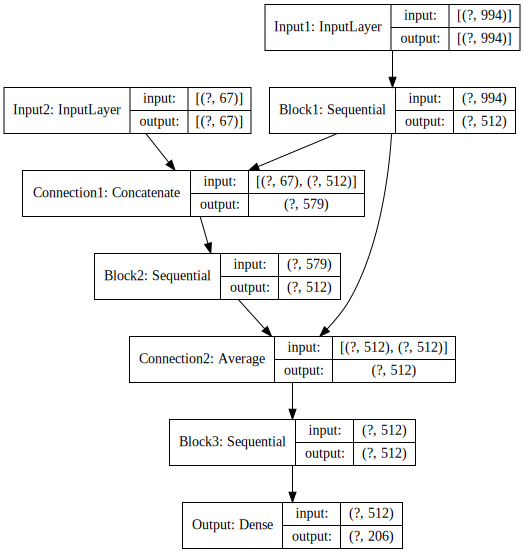

In [ ]:
if IN_COLAB:
    model_test = create_model_resnet(len(train.columns), len(train_pca.columns), len(target.columns))
    model_test.summary()
    display_svg(SVG(model_to_dot(model_test, show_shapes=True, dpi=72).create(prog="dot", format="svg")))

In [ ]:
def create_model_resnet_tuning(n_features, n_features_2, n_labels, params):
    n_hidden_layers = params["n_layers"]
    units = params["units"]
    activations = params["activations"]

    input_1 = L.Input(shape=(n_features,), name="Input1")
    input_2 = L.Input(shape=(n_features_2,), name="Input2")

    block_1 = tf.keras.Sequential(
        [
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(units[-3], activation=activations[-4])),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(units[n_hidden_layers - 1], activation=activations[-3])),
        ],
        name="Block1",
    )

    output_1 = block_1(input_1)
    connection_1 = L.Concatenate(name="Connection1")([input_2, output_1])

    layers_2 = []
    for i in range(n_hidden_layers):
        layers_2 += [
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(units[i], activation=activations[i])),
        ]
    block_2 = tf.keras.Sequential(layers_2, name="Block2")

    output_2 = block_2(connection_1)
    connection_2 = L.Average(name="Connection2")([output_1, output_2])

    block_3 = tf.keras.Sequential(
        [
            L.BatchNormalization(),
            tfa.layers.WeightNormalization(L.Dense(units[-2], activation=activations[-2])),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(units[-1], activation=activations[-1])),
            L.BatchNormalization(),
        ],
        name="Block3",
    )

    output_3 = block_3(connection_2)

    # output = L.Dense(n_labels, activation="sigmoid", name="Output")(output_3)
    output = L.Dense(n_labels, name="Output")(output_3)

    model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=output)

    return model

# Model - TabNet

In [ ]:
def create_model_tabnet(seed):
    tabnet_params = dict(
        n_d=32,
        n_a=32,
        n_steps=1,
        n_independent=1,
        n_shared=1,
        gamma=1.3,
        lambda_sparse=0,
        optimizer_fn=optim.Adam,
        optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
        mask_type="entmax",
        scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, threshold=1e-5, factor=0.1),
        scheduler_fn=torch_ReduceLROnPlateau,
        seed=seed,
        verbose=0,
    )

    model = TabNetRegressor(**tabnet_params)

    return model

In [ ]:
def create_model_tabnet_tuning(seed, params=None):
    tabnet_params = dict(
        n_d=params["dim"],
        n_a=params["dim"],
        n_steps=1,
        n_independent=1,
        n_shared=1,
        gamma=1.3,
        lambda_sparse=0,
        optimizer_fn=optim.Adam,
        optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
        mask_type="entmax",
        scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, threshold=1e-5, factor=0.1),
        scheduler_fn=torch_ReduceLROnPlateau,
        seed=seed,
        verbose=0,
    )

    model = TabNetRegressor(**tabnet_params)

    return model

# Training

In [ ]:
models = [
    {"model_name": "ResNet", "cv": "with_drug_id"},
    # {"model_name": "ResNet", "cv": "without_drug_id"},
    {"model_name": "TabNet", "cv": "with_drug_id"},
    # {"model_name": "TabNet", "cv": "without_drug_id"},
]
N_SEED = 3
N_STARTS = len(models) * N_SEED
N_SPLITS = 5
pre_train_models = ["ResNet"]

if IN_COLAB:
    models = [
        {"model_name": "ResNet", "cv": "with_drug_id"},
        {"model_name": "ResNet", "cv": "without_drug_id"},
        # {"model_name": "TabNet", "cv": "with_drug_id"},
        # {"model_name": "TabNet", "cv": "without_drug_id"},
    ]
    N_STARTS = len(models) * 1
    N_SPLITS = 5

In [ ]:
def learning(
    train_,
    train_pca_,
    target_,
    drug_,
    test_,
    test_pca_,
    N_STARTS=6,
    N_SPLITS=5,
    do_predict=False,
    transfer_learning_base=None,
    params=None,
):
    oof = {}
    predictions = {}

    for seed in range(N_STARTS):
        model_name = models[seed % len(models)]["model_name"]
        cv = models[seed % len(models)]["cv"]

        if not do_predict and model_name not in pre_train_models:
            continue

        seed_result = pd.DataFrame(np.zeros(target_.shape))
        prediction = pd.DataFrame(np.zeros(ss.shape))

        if do_predict:
            kfold_seed = random_seed + seed
        else:
            kfold_seed = seed

        fix_seed(kfold_seed)

        if "fold" in drug_.columns:
            drug_.drop(["fold"], axis=1, inplace=True)

        # LOCATE DRUGS
        vc = drug_.drug_id.value_counts()
        vc1 = vc.loc[(vc == 6) | (vc == 12) | (vc == 18)].index.sort_values()
        vc2 = vc.loc[(vc != 6) & (vc != 12) & (vc != 18)].index.sort_values()

        dct1 = {}
        dct2 = {}

        # STRATIFY DRUGS 18X OR LESS
        skf = MultilabelStratifiedKFold(n_splits=N_SPLITS, random_state=kfold_seed, shuffle=True)
        tmp = pd.concat([drug_, target_], axis=1).groupby("drug_id").mean().loc[vc1]
        for fold, (idxT, idxV) in enumerate(skf.split(tmp, tmp)):
            dd = {k: fold for k in tmp.index[idxV].values}
            dct1.update(dd)

        # STRATIFY DRUGS MORE THAN 18X
        skf = MultilabelStratifiedKFold(n_splits=N_SPLITS, random_state=kfold_seed, shuffle=True)
        tmp = drug_.loc[drug_.drug_id.isin(vc2)].reset_index(drop=True)
        for fold, (idxT, idxV) in enumerate(skf.split(tmp, tmp)):
            dd = {k: fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        # ASSIGN FOLDS
        drug_["fold"] = drug_.drug_id.map(dct1)
        drug_.loc[drug_.fold.isna(), "fold"] = drug_.loc[drug_.fold.isna(), "sig_id"].map(dct2)
        drug_.fold = drug_.fold.astype("int8")

        for n, (tr, te) in enumerate(
            MultilabelStratifiedKFold(n_splits=N_SPLITS, random_state=kfold_seed, shuffle=True).split(target_, target_)
        ):
            if cv == "with_drug_id":
                tr = drug_[drug_["fold"] != n].index
                te = drug_[drug_["fold"] == n].index

            start_time = time()

            # Build Data Sets
            if model_name == "ResNet":
                x_tr = [
                    train_.values[tr],
                    train_pca_.values[tr],
                ]
                x_val = [
                    train_.values[te],
                    train_pca_.values[te],
                ]
                y_tr, y_val = target_.astype(float).values[tr], target_.astype(float).values[te]
                x_tt = [test_.values, test_pca_.values]

            else:
                x_tr, x_val = train_.values[tr], train_.values[te]
                y_tr, y_val = target_.astype(float).values[tr], target_.astype(float).values[te]
                x_tt = test_.values

            # Build Model
            if model_name == "ResNet":
                if params is not None and params.get(model_name) is not None:
                    model = create_model_resnet_tuning(
                        len(train_.columns), len(train_pca_.columns), len(target_.columns), params[model_name]
                    )
                else:
                    model = create_model_resnet(len(train_.columns), len(train_pca_.columns), len(target_.columns))

                if transfer_learning_base is not None:
                    if params is not None and params.get(model_name) is not None:
                        model_base = create_model_resnet_tuning(
                            len(train_.columns),
                            len(train_pca_.columns),
                            len(transfer_learning_base.columns),
                            params[model_name],
                        )
                    else:
                        model_base = create_model_resnet(
                            len(train_.columns), len(train_pca_.columns), len(transfer_learning_base.columns)
                        )

            elif model_name == "TabNet":
                if params is not None and params.get(model_name) is not None:
                    model = create_model_tabnet_tuning(kfold_seed, params[model_name])
                else:
                    model = create_model_tabnet(kfold_seed)

            else:
                raise "Model name is invalid."

            if model_name == "TabNet":
                checkpoint_path = f"{model_name}_repeat:{seed}_fold:{n}"

                if transfer_learning_base is not None and model_name in pre_train_models:
                    model.load_model(checkpoint_path + ".zip")

                model.fit(
                    X_train=x_tr,
                    y_train=y_tr,
                    eval_set=[(x_val, y_val)],
                    eval_name=["val"],
                    eval_metric=["logits_ll"],
                    max_epochs=200,
                    patience=10,
                    batch_size=1024,
                    virtual_batch_size=32,
                    num_workers=1,
                    drop_last=False,
                    # loss_fn=F.binary_cross_entropy_with_logits,
                    loss_fn=SmoothBCEwLogits(smoothing=1e-6),
                )

                if PRE_TRAIN_NON_SCORED_TARGET:
                    try:
                        os.remove(checkpoint_path)
                    except OSError:
                        pass
                    model.save_model(checkpoint_path)

            else:
                model.compile(
                    optimizer=tfa.optimizers.AdamW(lr=1e-3, weight_decay=1e-5),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=1e-6),
                    metrics=logloss,
                )

                checkpoint_path = f"{model_name}_repeat:{seed}_fold:{n}.hdf5"

                if (
                    PRE_TRAIN_NON_SCORED_TARGET
                    and transfer_learning_base is not None
                    and model_name in pre_train_models
                ):
                    model_base.load_weights(checkpoint_path)
                    for layer in range(len(model_base.layers[:-1])):
                        model.layers[layer].set_weights(model_base.layers[layer].get_weights())

                if PRE_TRAIN_NON_SCORED_TARGET:
                    cb_checkpt = ModelCheckpoint(
                        checkpoint_path,
                        monitor="val_loss",
                        verbose=0,
                        save_best_only=True,
                        save_weights_only=True,
                        mode="min",
                    )
                reduce_lr_loss = ReduceLROnPlateau(
                    monitor="val_loss", factor=0.1, patience=5, verbose=0, min_delta=1e-5, min_lr=1e-5, mode="min"
                )
                early_stopping = EarlyStopping(
                    monitor="val_loss",
                    patience=10,
                    mode="min",
                    verbose=0,
                    min_delta=1e-5,
                    restore_best_weights=True,
                )
                if PRE_TRAIN_NON_SCORED_TARGET:
                    callbacks = [cb_checkpt, reduce_lr_loss, early_stopping]
                else:
                    callbacks = [reduce_lr_loss, early_stopping]
                model.fit(
                    x_tr,
                    y_tr,
                    validation_data=(x_val, y_val),
                    epochs=200,
                    batch_size=128,
                    callbacks=callbacks,
                    verbose=0,
                )

            val_predict = model.predict(x_val)
            val_predict = 1 / (1 + np.exp(-val_predict))
            seed_result.loc[te, :] += val_predict

            if do_predict:
                test_predict = model.predict(x_tt)
                test_predict = 1 / (1 + np.exp(-test_predict))
                prediction += test_predict / N_SPLITS

            if model_name == "TabNet":
                fold_score = np.min(model.history["val_logits_ll"])
            else:
                fold_score = metric(target_.loc[te].values, val_predict)

            print(
                f"[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}] {model_name} {cv}: Seed {seed}, Fold {n}:",
                fold_score,
            )

            K.clear_session()
            del model
            if "model_base" in globals():
                del model_base
            gc.collect()

        oof[f"{model_name}_{cv}_{seed}"] = seed_result
        predictions[f"{model_name}_{cv}_{seed}"] = prediction

    return oof, predictions

## Hyper parameter tuning

In [ ]:
def objective(trial):
    tuning_resnet = True
    tuning_tabnet = False

    params = {model["model_name"]: None for model in models}

    if TUNING_RESNET:
        n_layers = trial.suggest_int("n_layers", 2, 5)
        # n_layers = 5

        units = []
        for i in range(n_layers + 3):
            u = trial.suggest_categorical(f"units_{i}", [128, 256, 512, 1024])
            units.append(u)

        activations = []
        for i in range(n_layers + 4):
            a = trial.suggest_categorical(f"activations_{i}", ["relu", "elu", "selu", "swish"])
            activations.append(a)

        params["ResNet"] = {
            "n_layers": n_layers,
            "units": units,
            "activations": activations,
        }

    if TUNING_TABNET:
        dim = trial.suggest_int("dim", 30, 50)

        params["TabNet"] = {
            "dim": dim,
        }

    # Training
    if PRE_TRAIN_NON_SCORED_TARGET:
        _, _ = learning(
            train[: non_target.shape[0]],
            train_pca[: non_target.shape[0]],
            non_target,
            non_target_drug,
            test,
            test_pca,
            N_STARTS,
            N_SPLITS,
            params=params,
        )

    oof, predictions = learning(
        train,
        train_pca,
        target,
        target_drug,
        test,
        test_pca,
        N_STARTS,
        N_SPLITS,
        do_predict=True,
        transfer_learning_base=non_target,
        params=params,
    )

    initial_weights = [1.0 / N_STARTS for _ in range(N_STARTS)]
    y_true = target.values[: non_target.shape[0]]

    cv, auc, _ = cross_validation(y_true.shape, initial_weights, y_true, oof)

    return cv

In [ ]:
if HYPER_PARAMETER_TUNING:
    study = optuna.create_study()
    study.optimize(objective, n_trials=20)

In [ ]:
if HYPER_PARAMETER_TUNING:
    print("Best trial:")
    trial = study.best_trial

    print("  CV:  {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    print(optuna.importance.get_param_importances(study))

In [ ]:
if HYPER_PARAMETER_TUNING:
    raise "Finished parameter tuning."

## Normal training

In [ ]:
%%time

if PRE_TRAIN_NON_SCORED_TARGET:
    _, _ = learning(
        train[: non_target.shape[0]],
        train_pca[: non_target.shape[0]],
        non_target,
        non_target_drug,
        test,
        test_pca,
        N_STARTS,
        N_SPLITS,
    )

[00:58] ResNet with_drug_id: Seed 0, Fold 0: 0.004655067981920142
[00:52] ResNet with_drug_id: Seed 0, Fold 1: 0.004615971435655479
[00:50] ResNet with_drug_id: Seed 0, Fold 2: 0.00478727117796783
[00:51] ResNet with_drug_id: Seed 0, Fold 3: 0.004825039573716908
[00:50] ResNet with_drug_id: Seed 0, Fold 4: 0.004647948913825259
[01:26] ResNet without_drug_id: Seed 1, Fold 0: 0.004016432031088001
[01:27] ResNet without_drug_id: Seed 1, Fold 1: 0.0039276867967949405
[01:28] ResNet without_drug_id: Seed 1, Fold 2: 0.004036504242923631
[01:25] ResNet without_drug_id: Seed 1, Fold 3: 0.003960036585295028
[01:19] ResNet without_drug_id: Seed 1, Fold 4: 0.004054488517351672
CPU times: user 11min 54s, sys: 1min 47s, total: 13min 42s
Wall time: 11min 44s


In [ ]:
%%time

oof, predictions = learning(
    train,
    train_pca,
    target,
    target_drug,
    test,
    test_pca,
    N_STARTS,
    N_SPLITS,
    do_predict=True,
    transfer_learning_base=non_target,
)

[01:00] ResNet with_drug_id: Seed 0, Fold 0: 0.01797123393100388
[00:59] ResNet with_drug_id: Seed 0, Fold 1: 0.01834080100638195
[01:08] ResNet with_drug_id: Seed 0, Fold 2: 0.017792117124699164
[00:59] ResNet with_drug_id: Seed 0, Fold 3: 0.017913509434929968
[01:01] ResNet with_drug_id: Seed 0, Fold 4: 0.018074227825883162
[01:02] ResNet without_drug_id: Seed 1, Fold 0: 0.016706787096110436
[01:04] ResNet without_drug_id: Seed 1, Fold 1: 0.0167335581618759
[01:03] ResNet without_drug_id: Seed 1, Fold 2: 0.01730772458667894
[01:11] ResNet without_drug_id: Seed 1, Fold 3: 0.01669598889686348
[00:59] ResNet without_drug_id: Seed 1, Fold 4: 0.016807299790546768
CPU times: user 10min 52s, sys: 1min 38s, total: 12min 31s
Wall time: 10min 43s


## Cross Validation

In [ ]:
oof_weights = [1.0 / N_STARTS for _ in range(N_STARTS)]
model_weights = [1.0 / len(models) for _ in range(len(models))]
seed_weights = [1.0 / N_SEED for _ in range(N_SEED)]

y_true = target.values[: non_target.shape[0]]

print(f"===== OOF - CV =====")
for key, val in oof.items():
    print(f"OOF Key: {key}, CV: {metric(y_true, val.values[:y_true.shape[0]])}")

oof_by_model = {
    f"{model['model_name']}_{model['cv']}": {
        k: v for k, v in oof.items() if k.startswith(f"{model['model_name']}_{model['cv']}")
    }
    for model in models
}

blend_by_model = {}
for model, oof_ in oof_by_model.items():
    print(f"\n===== Model {model} - CV =====")
    _, _, blend_by_model[model] = cross_validation(y_true.shape, seed_weights, y_true, oof_)

print(f"\n===== Overall - CV =====")
_ = cross_validation(y_true.shape, model_weights, y_true, blend_by_model)

===== OOF - CV =====
OOF Key: ResNet_with_drug_id_0, CV: 0.01727335783474269
OOF Key: ResNet_without_drug_id_1, CV: 0.01585385414075689

===== Model ResNet_with_drug_id - CV =====
Blended CV: 0.018277068329351248, AUC : 0.6788976231466508

===== Model ResNet_without_drug_id - CV =====
Blended CV: 0.016905197984716933, AUC : 0.8117306940563536

===== Overall - CV =====
Blended CV: 0.017066247366274313, AUC : 0.7822454553899068


In [ ]:
optimize = False

if IN_COLAB:
    optimize = True

if optimize:
    # https://www.kaggle.com/gogo827jz/optimise-blending-weights-with-bonus-0#Bonus-(Lagrange-Multiplier)

    def lagrange_func(params):
        # weights, _lambda = params
        blend_ = blend(y_true.shape, params[:-1], blend_by_model)
        return metric(y_true, blend_) - params[-1] * (sum(params[:-1]) - 1)

    grad_l = grad(lagrange_func)

    def lagrange_obj(params):
        # weights, _lambda = params
        d = grad_l(params).tolist()
        return d[:-1] + [sum(params[:-1]) - 1]

    optimized_weights = fsolve(lagrange_obj, model_weights + [1.0])
    cross_validation(y_true.shape, optimized_weights[:-1], y_true, blend_by_model)

    print(f"Optimized weights: {optimized_weights[:-1]}")
    print(f"Check the sum of all weights: {sum(optimized_weights[:-1])}")

    final_weights = optimized_weights[:-1] * N_SEED
else:
    final_weights = model_weights * N_SEED

Blended CV: 0.016874690782863713, AUC : 0.8076360082415952
Optimized weights: [0.11575299 0.88424701]
Check the sum of all weights: 1.0


In [ ]:
predictions_by_model = {
    f"{model['model_name']}_{model['cv']}": {
        k: v for k, v in predictions.items() if k.startswith(f"{model['model_name']}_{model['cv']}")
    }
    for model in models
}

blend_by_model = {
    f"{model['model_name']}_{model['cv']}": pd.DataFrame(
        blend(ss.shape, final_weights, predictions_by_model[f"{model['model_name']}_{model['cv']}"])
    )
    for model in models
}

if IN_COLAB:
    pub_test_pseudo_label = pub_ss.drop("sig_id", axis=1)
    pub_test_pseudo_label.columns = range(206)
    blend_by_model["pub_test"] = pub_test_pseudo_label

for a, b in itertools.combinations(blend_by_model.keys(), 2):
    corr = blend_by_model[a].corrwith(blend_by_model[b], axis=1)
    print(f"Prediction correlation between {a} and {b}: {corr.mean()}")

Prediction correlation between ResNet_with_drug_id and ResNet_without_drug_id: 0.9068114448810981
Prediction correlation between ResNet_with_drug_id and pub_test: 0.9423120004396893
Prediction correlation between ResNet_without_drug_id and pub_test: 0.939484376799638


# Postprocessing

In [ ]:
# Weighted blend
submit_df.loc[:, target.columns] = blend(ss.shape, final_weights, predictions)

In [ ]:
submit_df.loc[test_df["cp_type"] == "ctl_vehicle", target.columns] = 0

# Output

In [ ]:
submit_df.to_csv("submission.csv", index=False)